In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# import torch
# torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
# print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

from Levenshtein import distance as Ldistance

import training_utils.dataset_utils as data_utils
import training_utils.partitioning_utils as pat_utils

import importlib
import training_utils.train_utils as train_utils
importlib.reload(train_utils)

<module 'training_utils.train_utils' from '/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/training_utils/train_utils.py'>

In [2]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

# batch_size = 20
learning_rate = 2e-5
EPOCHS = 15

In [27]:
## Model Class
### MiniClip 
# def gaussian_kernel(x, sigma):
#     return np.exp(-x**2 / (2 * sigma**2))

# def transform_vector(vector, sigma):

#     interacting_indices = np.where(vector == 1)[0]   # positions where vector == 1
#     transformed_vector = np.zeros_like(vector, dtype=float)
    
#     for i in range(len(vector)):
#         if vector[i] == 0:
#             distances = np.abs(interacting_indices - i)   # distance to all "1"s
#             min_distance = np.min(distances)              # closest "1"
#             transformed_vector[i] = gaussian_kernel(min_distance, sigma)
#         else:
#             transformed_vector[i] = 1.0
#     return transformed_vector

# def safe_shuffle(n, device):
#     shuffled = torch.randperm(n, device=device)
#     while torch.any(shuffled == torch.arange(n, device=device)):
#         shuffled = torch.randperm(n, device=device)
#     return shuffled

def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        
        # compute on TRAIN fold
        pos = (binder_labels == 1).sum()
        neg = (binder_labels == 0).sum()
        pos_weight = torch.tensor([neg / max(1, pos)], device=device)
        
        # loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)

        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [28]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

## Embeddings paths
binders_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
targets_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  4.756340736
Allocated memory:  4.0
Free memory:  0.317001216


#### Loading data frame

In [29]:
### Loading the dataset
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})

all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not

### Weights for binder/non-binders
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["class_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
# binder_nonbinder_weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["class_weight"]))

### Weights for target
N_bins = len(interaction_df["target_id_mod"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["target_id_mod"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["target_weight"] = interaction_df.target_id_mod.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])

### Combined weights
interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

In [30]:
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553


# 5-fold CV training + weighting of samples

In [31]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [32]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


In [33]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    train_targets = cv_splits[idx][1]
    print(f"Fold {idx+1} : validation targets : {val_targets}")

Fold 1 : validation targets : ['FGFR2', 'Mdm2', 'LTK']
Fold 2 : validation targets : ['SARS_CoV2_RBD', 'sntx', 'sntx_2', 'IL7Ra']
Fold 3 : validation targets : ['InsulinR', 'TrkA', 'IL10Ra']
Fold 4 : validation targets : ['EGFR', 'EGFR_2', 'EGFR_3', 'VirB8']
Fold 5 : validation targets : ['IL2Ra', 'Pdl1']


In [66]:
interaction_df.loc[interaction_df.target_id_mod.isin(cv_splits[1][1])].binder.value_counts()

binder
False    2876
True      337
Name: count, dtype: int64

#### Creating separate targets/ binder dataframes

In [34]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder", "class_weight", "target_weight", "combined_weight"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

### Class for loading binders/targets

In [35]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████████████████████████| 3532/3532 [00:04<00:00, 775.30it/s]


In [36]:
# checking if _get_by_name function gives the same output as index used
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Loading pretrained model for finetuning

In [37]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
device = torch.device("cuda:0")
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [50]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl))

    return listof_bindertargetlabel

ALL_btl_list = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)
# ALL_btl_list.__len__()
# ALL_btl_list.__getitem__(0)

binders = torch.stack([torch.as_tensor(b) for b,_,_ in ALL_btl_list])   # [N, L, D]
targets = torch.stack([torch.as_tensor(t) for _,t,_ in ALL_btl_list])   # [N, L, D]
labels  = torch.tensor([float(y) for _,_,y in ALL_btl_list], dtype=torch.float32)  # [N]

ALL_btl = TensorDataset(binders, targets, labels)
# ALL_btl[0]

In [41]:
### Combined weights (boost positives, reduce number of FGFR2 binder)
multipliers = []
for name in interaction_df["target_id_mod"]:
    if name == "FGFR2":
        multipliers.append(1)
    else:
        multipliers.append(5)
interaction_df["target_weight_FGFR2_reduced"] = interaction_df["target_weight"] * multipliers

### Combined weights
# interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Combined weights (boost positives)
multipliers = []
for binder in interaction_df["binder"]:
    if binder == False:
        multipliers.append(1)
    else:
        multipliers.append(2)
interaction_df["combined_weight_boost_pos"] = ((interaction_df["class_weight"]+interaction_df["target_weight_FGFR2_reduced"])/2) * multipliers

In [42]:
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight,target_weight_FGFR2_reduced,combined_weight_boost_pos
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395,0.003157,0.001658
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553,0.004735,0.002447
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553,0.004735,0.002447
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553,0.004735,0.002447
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553,0.004735,0.002447


In [56]:
assert labels.ndim == 1 and labels.shape[0] == binders.shape[0]
assert binders.dtype == targets.dtype
# assert binders.shape == targets.shape

In [43]:
u = interaction_df[['binder', 'target_id_mod', 'combined_weight_boost_pos']].drop_duplicates(subset=['target_id_mod', 'binder'])
print(u.sort_values('target_id_mod').to_string(index=False))
# or as a dict:
weight_map = u.set_index('target_id_mod')['combined_weight_boost_pos'].to_dict()

 binder target_id_mod  combined_weight_boost_pos
   True          EGFR                   0.003720
  False          EGFR                   0.001300
   True        EGFR_2                   0.002314
  False        EGFR_2                   0.000597
   True        EGFR_3                   0.079404
  False         FGFR2                   0.000094
   True         FGFR2                   0.001308
   True        IL10Ra                   0.015483
  False        IL10Ra                   0.007182
   True         IL2Ra                   0.006014
  False         IL2Ra                   0.002447
  False         IL7Ra                   0.000993
   True         IL7Ra                   0.003106
   True      InsulinR                   0.003950
  False      InsulinR                   0.001415
  False           LTK                   0.004814
   True           LTK                   0.010748
  False          Mdm2                   0.001707
   True          Mdm2                   0.004534
   True          Pdl

In [44]:
train_targets = cv_splits[1][1]
g = torch.Generator().manual_seed(SEED)

class PairListDataset(torch.utils.data.Dataset):
    # examples: list of (binder_emb, target_emb, label)
    # target_ids: parallel list of target_id_mod (same order)
    def __init__(self, examples, target_ids):
        assert len(examples) == len(target_ids)
        self.examples = examples
        self.target_ids = list(map(str, target_ids))

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        return (torch.as_tensor(b, dtype=torch.float32),
                torch.as_tensor(t, dtype=torch.float32),
                torch.tensor(float(y), dtype=torch.float32),
                self.target_ids[idx])  # <- keep the id

train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
train_weights_combined_boosted = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
train_target_ids = interaction_df.loc[train_idx, "target_id_mod"].astype(str).tolist()
train_binders_ds = PairListDataset([ALL_btl[idx] for idx in train_idx], target_ids=train_target_ids)

train_sampler = WeightedRandomSampler(weights=train_weights_combined_boosted, num_samples=len(train_binders_ds), replacement=True, generator = g)
train_loader   = DataLoader(train_binders_ds,  batch_size=20, sampler=train_sampler)


for bi, batch in enumerate(train_loader):
    _, _, labels, ids = batch
    c = Counter(ids)
    print(f"Batch {bi}: {dict(c)}  | positives={int(labels.sum().item())} / {labels.numel()}")
    if bi == 10: break  # first 5 batches

Batch 0: {'IL2Ra': 1, 'TrkA': 1, 'Pdl1': 1, 'EGFR_2': 3, 'FGFR2': 4, 'LTK': 1, 'InsulinR': 2, 'EGFR_3': 3, 'EGFR': 1, 'Mdm2': 1, 'VirB8': 1, 'IL10Ra': 1}  | positives=9 / 20
Batch 1: {'InsulinR': 2, 'FGFR2': 2, 'VirB8': 3, 'TrkA': 1, 'IL10Ra': 1, 'Pdl1': 1, 'Mdm2': 7, 'EGFR_3': 2, 'EGFR': 1}  | positives=10 / 20
Batch 2: {'VirB8': 2, 'Mdm2': 3, 'EGFR_3': 2, 'EGFR': 2, 'FGFR2': 3, 'Pdl1': 1, 'IL2Ra': 2, 'LTK': 2, 'InsulinR': 2, 'TrkA': 1}  | positives=11 / 20
Batch 3: {'Mdm2': 4, 'VirB8': 1, 'FGFR2': 3, 'IL2Ra': 1, 'LTK': 3, 'IL10Ra': 1, 'Pdl1': 2, 'EGFR': 2, 'InsulinR': 1, 'EGFR_3': 2}  | positives=9 / 20
Batch 4: {'FGFR2': 5, 'EGFR_3': 4, 'LTK': 2, 'IL10Ra': 3, 'EGFR': 2, 'VirB8': 1, 'Pdl1': 1, 'EGFR_2': 2}  | positives=10 / 20
Batch 5: {'Pdl1': 2, 'IL2Ra': 3, 'FGFR2': 3, 'LTK': 1, 'IL10Ra': 4, 'EGFR_2': 2, 'InsulinR': 1, 'Mdm2': 2, 'TrkA': 1, 'EGFR_3': 1}  | positives=9 / 20
Batch 6: {'FGFR2': 7, 'IL10Ra': 3, 'VirB8': 1, 'EGFR': 1, 'EGFR_3': 3, 'Pdl1': 3, 'InsulinR': 1, 'TrkA': 1}  |

### Training loop

In [45]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

all_hist = []

class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset, 
                 optimizer, EPOCHS, runID, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False, 
                 v=False, wandb_tracker=False, split_id=None):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):
        
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                av_pos = float(np.mean(scores[pos_mask])) if pos_mask.any() else float("nan")
                av_neg = float(np.mean(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = av_pos - av_neg if np.isfinite(av_pos) and np.isfinite(av_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_mean_logit": av_pos,
                    "val_neg_mean_logit": av_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Val AUPR,▁
Val AUROC,▁
Val Loss,▁
Val AUPR,0.08435
Val AUROC,0.36873
Val Loss,9.28673


Training model 3aa1dcdb-f14e-46fb-9e8a-0e45139b1188


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:16<00:00,  6.73it/s]


Before training - Val Loss 9.9952 | Val AUROC 0.4169 | Val AUPR 0.0968


Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.53it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [00:43<06:30, 43.35s/it]

EPOCH 1 - Train Loss 1.0117 | Val Loss 0.4157 | Val AUROC 0.6789 | Val AUPR 0.2890



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [01:26<05:44, 43.08s/it]

EPOCH 2 - Train Loss 0.5323 | Val Loss 0.4313 | Val AUROC 0.6909 | Val AUPR 0.2860



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [02:09<05:00, 42.98s/it]

EPOCH 3 - Train Loss 0.4734 | Val Loss 0.3617 | Val AUROC 0.6513 | Val AUPR 0.2516



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [02:52<04:17, 42.98s/it]

EPOCH 4 - Train Loss 0.4486 | Val Loss 0.5091 | Val AUROC 0.6369 | Val AUPR 0.2644



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [03:35<03:34, 42.97s/it]

EPOCH 5 - Train Loss 0.3848 | Val Loss 0.4565 | Val AUROC 0.6741 | Val AUPR 0.2780



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [04:17<02:51, 42.96s/it]

EPOCH 6 - Train Loss 0.4039 | Val Loss 0.3280 | Val AUROC 0.6758 | Val AUPR 0.2606



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [05:00<02:08, 42.98s/it]

EPOCH 7 - Train Loss 0.3943 | Val Loss 0.4384 | Val AUROC 0.6138 | Val AUPR 0.2381



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.53it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [05:43<01:25, 42.98s/it]

EPOCH 8 - Train Loss 0.3431 | Val Loss 0.3536 | Val AUROC 0.6767 | Val AUPR 0.2340



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.54it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [06:27<00:42, 42.99s/it]

EPOCH 9 - Train Loss 0.2909 | Val Loss 0.6579 | Val AUROC 0.6767 | Val AUPR 0.2644



Running through epoch: 100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:25<00:00,  2.53it/s]

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:10<00:00, 43.00s/it]


EPOCH 10 - Train Loss 0.3058 | Val Loss 0.4099 | Val AUROC 0.6437 | Val AUPR 0.2252


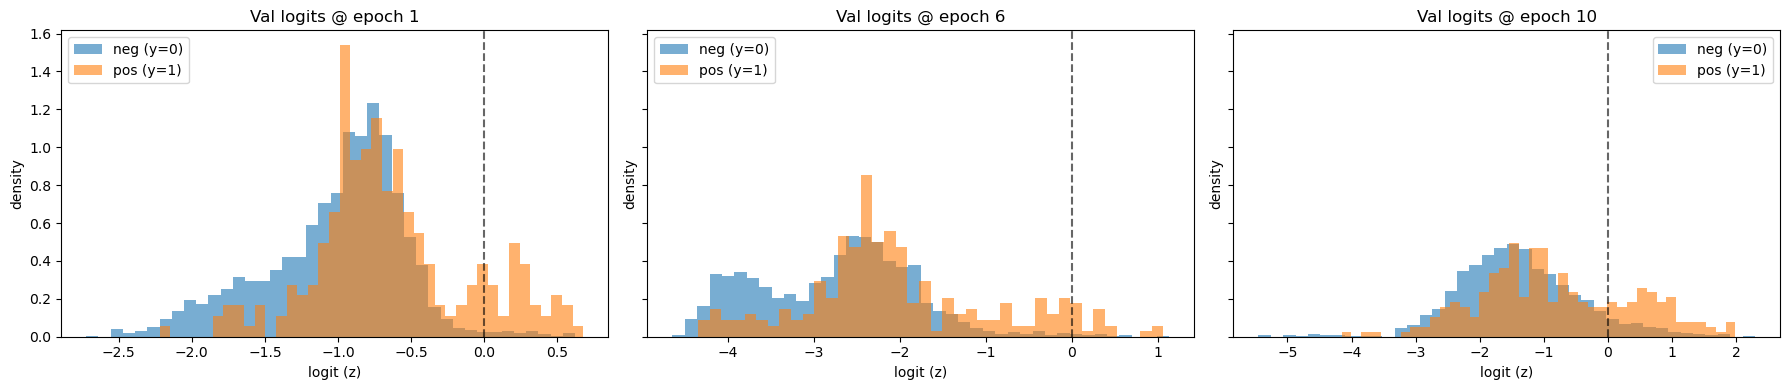

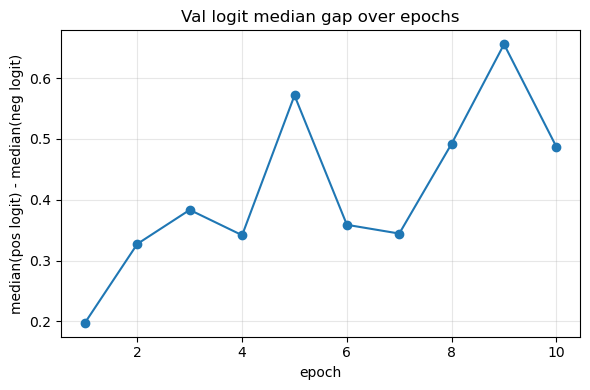

Train Loss,█▃▃▃▂▂▂▂▁▁
Val AUPR,▁██▇▇█▇▆▆▇▆
Val AUROC,▁██▇▇██▆██▇
Val Loss,█▁▁▁▁▁▁▁▁▁▁
val_logit_gap,▁▃▂▅█▆▄▅▇▄
val_neg_mean_logit,▆▆▄▇▆▁▆▄█▅
val_pos_mean_logit,▅▅▄▆▆▁▅▃█▄
Train Loss,0.30585
Val AUPR,0.22522
Val AUROC,0.64373
Val Loss,0.40986


Training model 3aa1dcdb-f14e-46fb-9e8a-0e45139b1188


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]


Before training - Val Loss 9.7375 | Val AUROC 0.4885 | Val AUPR 0.1588


Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  10%|█████████▌                                                                                      | 1/10 [01:06<09:56, 66.26s/it]

EPOCH 1 - Train Loss 0.7026 | Val Loss 0.8808 | Val AUROC 0.3333 | Val AUPR 0.1220



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  20%|███████████████████▏                                                                            | 2/10 [02:12<08:49, 66.17s/it]

EPOCH 2 - Train Loss 0.4635 | Val Loss 0.7928 | Val AUROC 0.3891 | Val AUPR 0.1326



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.54it/s]

Epochs:  30%|████████████████████████████▊                                                                   | 3/10 [03:18<07:42, 66.07s/it]

EPOCH 3 - Train Loss 0.4228 | Val Loss 1.0249 | Val AUROC 0.3559 | Val AUPR 0.1245



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  40%|██████████████████████████████████████▍                                                         | 4/10 [04:24<06:36, 66.11s/it]

EPOCH 4 - Train Loss 0.4018 | Val Loss 1.0831 | Val AUROC 0.3447 | Val AUPR 0.1237



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.52it/s]

Epochs:  50%|████████████████████████████████████████████████                                                | 5/10 [05:30<05:30, 66.19s/it]

EPOCH 5 - Train Loss 0.3686 | Val Loss 1.1122 | Val AUROC 0.3602 | Val AUPR 0.1266



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [06:37<04:24, 66.22s/it]

EPOCH 6 - Train Loss 0.2877 | Val Loss 1.2120 | Val AUROC 0.2846 | Val AUPR 0.1139



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [07:43<03:18, 66.20s/it]

EPOCH 7 - Train Loss 0.2530 | Val Loss 1.2937 | Val AUROC 0.3070 | Val AUPR 0.1174



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.53it/s]

Epochs:  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [08:49<02:12, 66.20s/it]

EPOCH 8 - Train Loss 0.2084 | Val Loss 1.2767 | Val AUROC 0.3415 | Val AUPR 0.1226



Running through epoch: 100%|██████████████████████████████████████████████████████████████████████████████| 161/161 [01:03<00:00,  2.54it/s]

Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [09:55<01:06, 66.16s/it]

EPOCH 9 - Train Loss 0.1654 | Val Loss 1.3104 | Val AUROC 0.2713 | Val AUPR 0.1136



Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [10:31<01:10, 70.22s/it]


KeyboardInterrupt: 

In [46]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 10
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="CLIP_PPint_metaanalysis",
            name=f"CV_split{i+1}_combined_weighting_boost_positives",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

In [ ]:
# batch_size = 20
# learning_rate = 2e-5
# EPOCHS = 5
# # EPOCHS = 15

# # login once (env var preferred)
# # if use_wandb:
# #     import wandb
# #     wandb.login()

# model = MiniCLIP_w_transformer_crossattn()
# optimizer = AdamW(model.parameters(), lr=learning_rate)

# # loaders
# train_loader = train_loader
# val_loader   = val_loader

# # accelerator
# accelerator = Accelerator()
# device = accelerator.device
# model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

# # wandb
# if use_wandb:
#     run = wandb.init(
#         project="CLIP_PPint_metaanalysis",
#         name=f"class_weighting_CVsplit1{runID}",
#         # group="cv_splits",
#         config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
#                 "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
#     )
#     wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
# else:
#     run = None

# # train
# training_wrapper = TrainWrapper_MetaAnal(
#     model=model,
#     training_loader=train_loader,
#     validation_loader=val_loader,
#     test_dataset=val_binders,   # ok if you truly want “full val”
#     optimizer=optimizer,
#     EPOCHS=EPOCHS,
#     runID=runID,
#     device=device,
#     model_save_steps=model_save_steps,
#     model_save_path=trained_model_dir,
#     v=True,
#     wandb_tracker=run,
#     split_id=i+1
# )

# training_wrapper.train_model()

# # cleanup between splits
# if use_wandb:
#     wandb.finish()
# del training_wrapper, model, optimizer, train_loader, val_loader
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
# try:
#     accelerator.free_memory()
# except AttributeError:
#     pass

`validation_dataset` / `training_dataset` store embedding of binder, embedding of target and label (binder - 1, non-binder - 0)